In [612]:
import ugradio
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pf
import lolfunctions
from astropy import units as u
import glob
import doppler
from mpl_toolkits.mplot3d import Axes3D
import scipy as sci
%matplotlib inline

In [613]:
def peak_finder(signal_array, thresh):
    threshold = thresh*(999./1000)
    peaks = []                                                    
    for i in range(2,len(signal_array)-2): 
        if signal_array[i] > signal_array[i+1] and signal_array[i] > signal_array[i-1] and signal_array[i] > signal_array[i-2] and signal_array[i] > signal_array[i+2]:  
            if signal_array[i] > threshold: # or could do ==threshhold and set thresh = .max()                    
                peaks.append(i)
    return peaks

def func(filename):
    lolavgs = np.array([])
    for i in np.arange(len(filename)):
        files_getdata = pf.getdata(filename[i])
        files_headers = pf.getheader(filename[i])
        files_open = pf.open(filename[i])
        
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        avgs = np.zeros(len(files_getdata))
        for j in np.arange(nspec):
            specs = np.sqrt((files_open[j+1].data['auto1_real'])**2 + (files_open[j+1].data['auto0_real'])**2)
            avgs = avgs + specs

        avgs = avgs/nspec
        meanavgs = avgs - np.mean(avgs)
        cutavgs = meanavgs[2500:-3500]
        if i == 0:
            lolavgs = np.append(lolavgs, cutavgs)
        else:
            lolavgs = np.vstack((lolavgs, cutavgs))
            
    return lolavgs


In [614]:
def func_noise(filename):
    lolavgs = np.array([])
    for i in np.arange(len(filename)):
        files_getdata = pf.getdata(filename[i])
        files_headers = pf.getheader(filename[i])
        files_open = pf.open(filename[i])
        
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        avgs = np.zeros(len(files_getdata))
        for j in np.arange(nspec):
            specs = files_open[j+1].data['auto0_real']
            avgs = avgs + specs
            
        avgs = avgs/nspec
        meanavgs = avgs - np.mean(avgs)
        cutavgs = meanavgs[3900:-3900]
        if i == 0:
            lolavgs = np.append(lolavgs, cutavgs)
        else:
            lolavgs = np.vstack((lolavgs, cutavgs))
    return lolavgs

In [679]:
def find_spec_peaks(filename, avgs636, avgs635):
    peaks = np.array([])
    spectras =np.array([])
    for i in np.arange(len(avgs636)):
        i = int(i)
        files_headers = pf.getheader(filename[i])

        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']

        cv635 = lolfunctions.airPLS(avgs635[i], lambda_= 50)[1200:,]
        cv636 = lolfunctions.airPLS(avgs636[i], lambda_= 50)[1200:,]

        flatavgs635 = avgs635[i][1200:,] - cv635
        flatavgs636 = avgs636[i][1200:,] - cv636

        sub = flatavgs635 - flatavgs636


        newsub = np.array([])
        for j in range(len(sub)):
            if j < 400 and sub[j] == max(sub[0:400]):
                newsub = np.append(newsub, 0)
            else:
                newsub = np.append(newsub, sub[j])


        newsub2 = np.array([])   
        for k in range(len(newsub)):
            if k < 400 and newsub[k] == max(newsub[0:400]):
                newsub2 = np.append(newsub2, 0)
            else:
                newsub2 = np.append(newsub2, newsub[k])

        if i == 0:
            spectras = np.append(spectras, newsub2)
        else:
            spectras = np.vstack((spectras, newsub2))

        LO = 635
        freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[2500:-3500]

        fpeaks = peak_finder(newsub2, max(newsub2))

        cents = np.array([])
        
        for g in fpeaks:
            cents = np.append(cents, lolfunctions.centroid(freqs[1200:,][g-1:g+1],newsub2[g-1:g+1]))

        cents = np.mean(cents)
        #print(i,cents)
        peaks = np.append(peaks,cents)
        
#         plt.figure(figsize=(8,5))
#         plt.plot(freqs[1200:,], newsub2)
#         print 'Peak Frequency =',cents, 'MHz'
#         plt.axvline(cents, c='red')
#         plt.title(i, fontsize=17)
#         plt.xlabel('Frequency [MHZ]', fontsize=17)
#         plt.ylabel('Power', fontsize=17)
#         plt.grid(True)
#         plt.show()
        
    return peaks, spectras

In [616]:
def find_lb_radec_jd(filename):
    gal_l = np.array([])
    gal_b = np.array([])
    RAs = np.array([])
    DECs = np.array([])
    JD = np.array([])
    for i in np.arange(int(len(filename))):
        head = pf.getheader(filename[i])
        glon = head['L']
        glat = head['B']
        gal_l = np.append(gal_l,glon)
        gal_b = np.append(gal_b,glat)
        ra = head['RA']
        dec = head['DEC']
        RAs = np.append(RAs,ra)
        DECs = np.append(DECs,dec)
        jd = head['JD']
        JD = np.append(JD,jd)
    return gal_l, gal_b, RAs, DECs, JD

In [617]:
noiseON = glob.glob('420_data/420_data/LO_*ON*.fits')
noiseOFF = glob.glob('420_data/420_data/LO_*OFF*.fits')

files635 = glob.glob('420_data/420_data/420_data_2/LO_635*.fits')
files636 = glob.glob('420_data/420_data/420_data_2/LO_636*.fits')

files635_2 = glob.glob('420_data_3/LO_635*.fits')
files636_2 = glob.glob('420_data_3/LO_636*.fits')

files635_3 = glob.glob('423_data/LO_635*.fits')
files636_3 = glob.glob('423_data/LO_636*.fits')

In [618]:
# avgON = func_noise(noiseON)
# avgOFF = func_noise(noiseOFF)

# avg635 = func(files635)
# avg636 = func(files636)

# avg635_2 = func(files635_2)
# avg636_2 = func(files636_2)

# avg635_3 = func(files635_3)
# avg636_3 = func(files636_3)

In [619]:
# np.savetxt('avgON', avgON)
# np.savetxt('avgOFF', avgOFF)

In [689]:
files_headers = pf.getheader(noiseOFF[0])
files_headers2 = pf.getheader(files635[0])
files_headers
files_headers

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                    5 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

In [620]:
avgON = np.loadtxt('avgON') # First Polarization Only
avgOFF = np.loadtxt('avgOFF')# Firsr Polarization Only
avg635 = np.loadtxt('avg635')
avg636 = np.loadtxt('avg636')
avg635_2 = np.loadtxt('avg635_2')
avg636_2 = np.loadtxt('avg636_2')
avg635_3 = np.loadtxt('avg635_3')
avg636_3 = np.loadtxt('avg636_3')

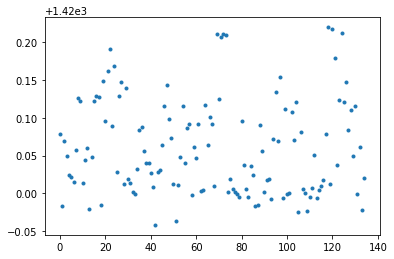

In [621]:
################################## PEAKS FOR NOISE ON ############################
peaksON = np.array([])
spectraON = np.array([])
for i in np.arange(135):
    cvON = lolfunctions.airPLS(avgON[i], lambda_=50)
    subON = avgON[i] - cvON
    
    files_headers = pf.getheader(noiseON[i])
    nspec = files_headers['NSPEC']
    res = files_headers['RES']
    nchan = files_headers['NCHAN']
    
    if i ==0:
        spectraON = np.append(spectraON, subON)
    else:
        spectraON = np.vstack((spectraON, subON))
    
    
    LO = 635
    freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[3900:-3900]

    
    fpeaks = peak_finder(subON, subON[np.argmax(subON)-15])
    cents = np.array([])
    
    for g in fpeaks:
        cents = np.append(cents, lolfunctions.centroid(freqs[g-1:g+1],subON[g-1:g+1]))

    cents = np.mean(cents)
    peaksON = np.append(peaksON,cents)
    
#     print 'Peak Frequency =',cents, 'MHz'
#     plt.figure(figsize=(8,5))
#     plt.plot(freqs, subON)
#     plt.axvline(cents, c='red')
#     plt.title(i, fontsize=17)
#     plt.xlabel('Frequency [MHZ]', fontsize=17)
#     plt.ylabel('Power', fontsize=17)
#     plt.grid(True)
#     plt.show()
plt.plot(peaksON,'.')

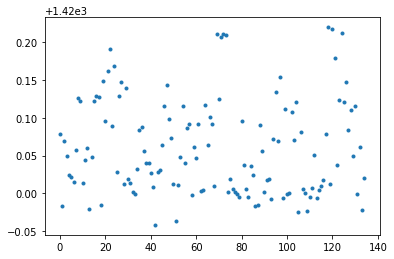

In [622]:
plt.plot(peaksON,'.')

(135L,)


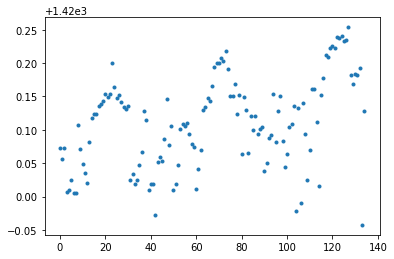

In [623]:
########################## PEAKS FOR NOISE OFF ##################################
spectraOFF = np.array([])
peaksOFF = np.array([])
for i in np.arange(135):
    cvOFF = lolfunctions.airPLS(avgOFF[i], lambda_=500)
    subOFF = avgOFF[i] - cvOFF
    
    files_headers = pf.getheader(noiseOFF[i])
    nspec = files_headers['NSPEC']
    res = files_headers['RES']
    nchan = files_headers['NCHAN']
    
    LO = 635
    freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[3900:-3900]

    if i ==0:
        spectraOFF = np.append(spectraOFF, subOFF)
    else:
        spectraOFF = np.vstack((spectraOFF, subOFF))
    
    
    
    fpeaks = peak_finder(subOFF, subOFF[np.argmax(subOFF)-15])
    
    centsOFF = np.array([])
    for g in fpeaks:
        centsOFF = np.append(centsOFF, lolfunctions.centroid(freqs[g-1:g+1],subOFF[g-1:g+1]))

    centsOFF = np.mean(centsOFF)
    peaksOFF = np.append(peaksOFF,centsOFF)
    
#     print 'Peak Frequency =',cents, 'MHz'
#     plt.figure(figsize=(8,5))
#     plt.plot(freqs, subOFF,'.')
#     plt.axvline(centsOFF, c='red')
#     plt.title(i, fontsize=17)
#     plt.xlabel('Frequency [MHZ]', fontsize=17)
#     plt.ylabel('Power', fontsize=17)
#     plt.grid(True)
#     plt.show()
plt.plot(peaksOFF,'.')
print peaksOFF.shape

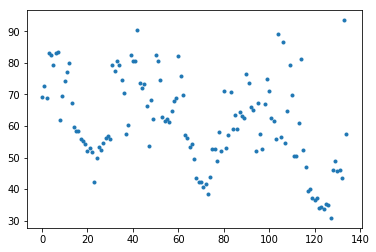

In [624]:
f0 = 1420.4
c = 3e5 #km/s
df = peaksOFF - f0
v = -(df/f0)*c
plt.plot(v,'.')

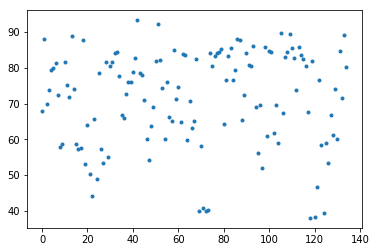

In [625]:
f0 = 1420.4
c = 3e5 #km/s
df = peaksON - f0
v = -(df/f0)*c
plt.plot(v,'.')

In [626]:
print avgON.shape
print avgOFF.shape

print avg635.shape
print avg636.shape

print avg635_2.shape
print avg636_2.shape

print avg635_3.shape
print avg636_3.shape

(135L, 392L)
(135L, 392L)
(580L, 2192L)
(580L, 2192L)
(846L, 2192L)
(846L, 2192L)
(110L, 2192L)
(110L, 2192L)


In [627]:
############################# FINDING ALL THE PEAK FREQUENCIES ####################################
peaks1, spec1 = find_spec_peaks(files635, avg636,avg635)
peaks2, spec2 = find_spec_peaks(files635_2, avg636_2,avg635_2)
peaks3, spec3 = find_spec_peaks(files635_3, avg636_3,avg635_3)

C:\Users\verde\Anaconda3\envs\python2\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\verde\Anaconda3\envs\python2\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [628]:
peaks1 = np.loadtxt('peaks1')
peaks2 = np.loadtxt('peaks2')
peaks3 = np.loadtxt('peaks3')
spec1 = np.loadtxt('spec1')
spec2 = np.loadtxt('spec2')
spec3 = np.loadtxt('spec3')

In [629]:
print(spec1.shape)

(580L, 992L)


In [630]:
####################################### FINDING ALL THE LONG, LAT, RA, DEC AND JD ############################
glonOFF,glatOFF, raOFF,decOFF,jdOFF = find_lb_radec_jd(noiseOFF)
glon1 ,glat1, ra1, dec1, jd1 = find_lb_radec_jd(files635)
glon2 ,glat2, ra2, dec2, jd2 = find_lb_radec_jd(files635_2)
glon3 ,glat3, ra3, dec3, jd3 = find_lb_radec_jd(files635_3)


In [631]:
##################### SAVING THE FILES FOR EASIER LOAD #######################################
# np.savetxt('spec1',spec1)
# np.savetxt('peaks1',peaks1)
# np.savetxt('spec2',spec2)
# np.savetxt('peaks2',peaks2)
# np.savetxt('spec3',spec3)
# np.savetxt('peaks3',peaks3)

In [632]:
############## STICHING THE FILES TOGETHER ################
print peaksOFF.shape
print peaks1.shape
total_peaks = np.concatenate((peaksOFF, peaks1, peaks2, peaks3),axis=0)
total_jd = np.concatenate((jdOFF, jd1, jd2, jd3),axis=0)
total_ra = np.concatenate((raOFF, ra1, ra2, ra3),axis=0)
total_dec = np.concatenate((decOFF, dec1, dec2, dec3),axis=0)
total_glon = np.concatenate((glonOFF, glon1, glon2, glon3),axis=0)
total_glat = np.concatenate((glatOFF, glat1, glat2, glat3),axis=0)

(135L,)
(580L,)


In [633]:
v_corrected = np.array([])
for i in range(int(len(total_jd))):
    vel = doppler.get_projected_velocity(total_ra[i],total_dec[i],total_jd[i],obs_lat=37.9183, obs_lon=-122.1067, 
        obs_alt=304, epoch=2451545.)
    v_corrected = np.append(v_corrected, float(vel/1000))
    
f0 = 1420.4
c = 3e5 #km/s
df = total_peaks - f0
v = -(df/f0)*c

In [634]:
corr_v = v - v_corrected

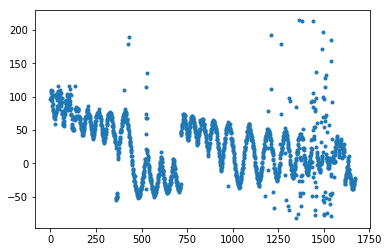

In [635]:
plt.plot(corr_v, '.')

Text(0,0.5,'Galactic Latitude [Degree]')

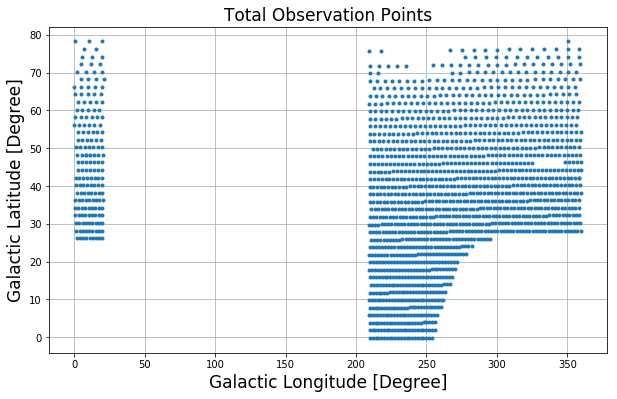

In [636]:
plt.figure(figsize=(10,6))
plt.plot(total_glon,total_glat,'.')
plt.grid(True)
plt.title('Total Observation Points', fontsize=17)
plt.xlabel('Galactic Longitude [Degree]',fontsize=17)
plt.ylabel('Galactic Latitude [Degree]',fontsize=17)

In [677]:
def plot_gal_sphere(l,b,vel,org=0, projection='mollweide'):
    ''' l, b are arrays of the same length.
    l takes values in [0,360), b in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(l+360,360) # shift az values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    tick_labels = np.array([210, 240, 270, 300, 330, 0, 30, 60, 90, 120, 150])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection=projection)
    yee = ax.scatter(np.radians(x),np.radians(b),c=vel,marker=',')  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title('Doppler Velocity Projection',fontsize = 50)
    ax.title.set_fontsize(25)
    ax.set_xlabel("Galactic Longitude [$\degree$]",fontsize = 50)
    ax.xaxis.label.set_fontsize(25)
    ax.set_ylabel("Galactic Latitude [$\degree$]",fontsize=50)
    ax.yaxis.label.set_fontsize(25)
    cbar = plt.colorbar(yee)
    cbar.set_label('Correctec Velocities [km/s]',fontsize = 20)
    
   
    ax.grid(True)

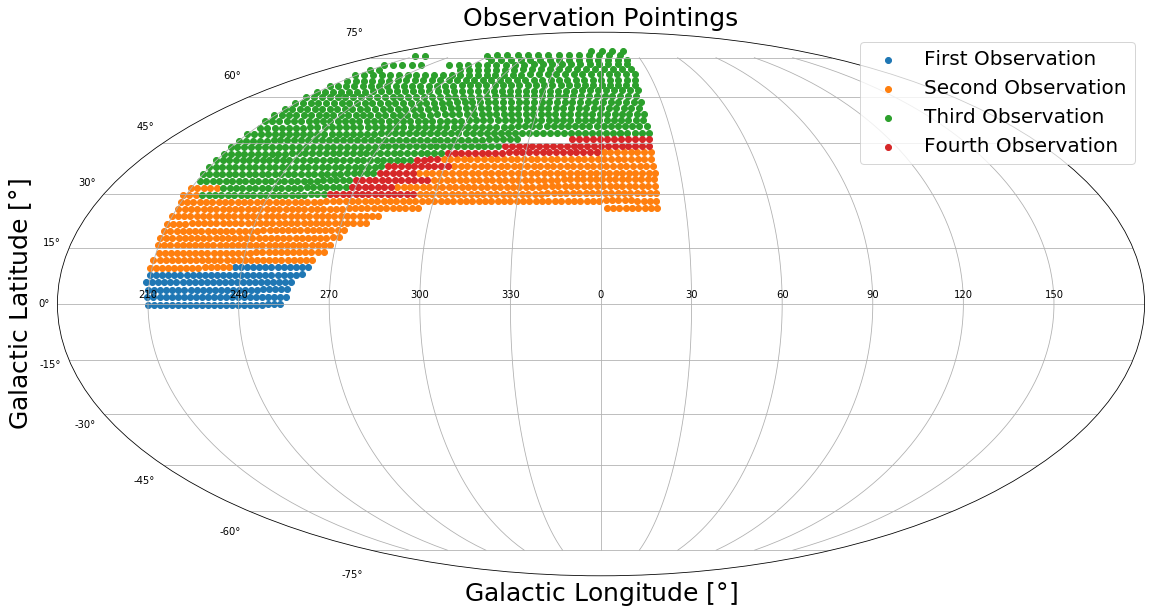

In [674]:

''' l, b are arrays of the same length.
l takes values in [0,360), b in [-90,90],
which represent angles in degrees.
org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
title is the title of the figure.
projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
'''
projection='mollweide'
org = 0
x= glonOFF
x2= glon1
x3 = glon2
x4 = glon3

b1 = glatOFF
b2=glat1
b3=glat2
b4 = glat3

x = np.remainder(x+360,360) # shift az values
x2 = np.remainder(x2+360,360)
x3 = np.remainder(x3+360,360)
x4 = np.remainder(x4+360,360)
ind = x>180
ind2 = x2>180
ind3 = x3>180
ind4 = x4>180
x[ind] -=360 
x2[ind2] -=360
x3[ind3] -=360# scale conversion to [-180, 180]
x4[ind4] -=360
tick_labels = np.array([210, 240, 270, 300, 330, 0, 30, 60, 90, 120, 150])
tick_labels = np.remainder(tick_labels+360+org,360)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection=projection)
yee = ax.scatter(np.radians(x),np.radians(b1)) # convert degrees to radians
yee2 = ax.scatter(np.radians(x2),np.radians(b2))
yee3 = ax.scatter(np.radians(x3),np.radians(b3))
yee4 = ax.scatter(np.radians(x4),np.radians(b4))
ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
ax.set_title('Observation Pointings',fontsize = 50)
ax.title.set_fontsize(25)
ax.set_xlabel("Galactic Longitude [$\degree$]",fontsize = 50)
ax.xaxis.label.set_fontsize(25)
ax.set_ylabel("Galactic Latitude [$\degree$]",fontsize=50)
ax.yaxis.label.set_fontsize(25)
ax.legend(['First Observation','Second Observation','Third Observation','Fourth Observation'],fontsize=20)
   
ax.grid(True)

In [638]:
corr_v.max()

214.61616041061757

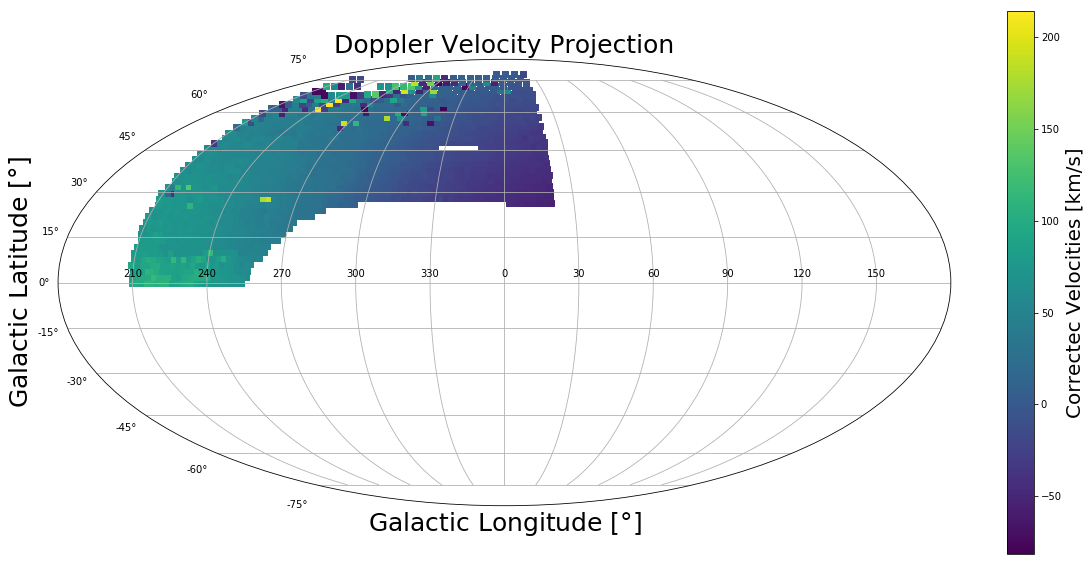

In [678]:
plot_gal_sphere(total_glon,total_glat, corr_v)

In [640]:
def func_noise2(filename):
    lolavgs = np.array([])
    for i in np.arange(len(filename)):
        files_getdata = pf.getdata(filename[i])
        files_headers = pf.getheader(filename[i])
        files_open = pf.open(filename[i])
        
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        avgs = np.zeros(len(files_getdata))
        for j in np.arange(nspec):
            specs = files_open[j+1].data['auto0_real']
            avgs = avgs + specs
            
        avgs = avgs/nspec
        #meanavgs = avgs - np.mean(avgs)
        cutavgs = avgs[3900:-3900]
        if i == 0:
            lolavgs = np.append(lolavgs, cutavgs)
        else:
            lolavgs = np.vstack((lolavgs, cutavgs))
    return lolavgs

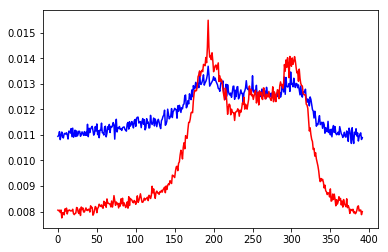

In [641]:
avgON2 = func_noise2(noiseON)
avgOFF2 = func_noise2(noiseOFF)

plt.plot(avgON2[0],'b')
plt.plot(avgOFF2[0],'r')
plt.show()

In [642]:
##### BRIGHTNESS TEMPERATURE ######

t_n = 70 #kelvin of first polarization
tbz = np.zeros(392)
for i in np.arange(135):
    g_tot = (avgON2[i] - avgOFF2[i])/t_n # total gain of each noise spectra
    tb = avgOFF2[i]/g_tot #brightness temperature
    tbz = tbz + tb
avgtb = tbz/135
print np.median(avgtb)

320.580833175


In [657]:
t_n = 70 #kelvin of first polarization
g_tot = (avgON2[0] - avgOFF2[0])/t_n # total gain of each noise spectra
tb = avgOFF2[0]/g_tot #brightness temperature
print np.median(tb)

204.815976857


In [643]:
print avgtb.shape
print freqs.shape

(392L,)
(392L,)


In [644]:
print np.median(avgtb)
print(avgtb.shape)

320.580833175
(392L,)


In [645]:
def loadnpz(path):
    """Loads npz files."""
    a = np.load(path)
    return dict(zip(("data1{}".format(k) for k in a), (a[k] for k in a)))['data1arr_0']

# load in some sample data
y_data = loadnpz('test_spectra.npz')
x_data = loadnpz('test_freqs.npz')

def multiple_peak_finder(signal, threshold = None, width = 1, separation = 1):
    """
    Finds many peaks in a set of data
    
    Parameters
    ----------
    
    signal (numpy array) : The data.
    threshold (float) default = np.mean(sigal):  Data below this value is not considered to be a peak. 
    
    width (int) default = 1: How many data points on each side to compare a possible peak to.
                             Increasing this reduces the number of found peaks.
                             
    separation (int) default = 1: How far apart the peaks must be ( in indices)
                                  Increasing this reduces the number of found peaks.
    
    Returns
    -------
    returns a list of the INDEX locations of the peaks from the signal
    """

    peak_indicies = []

    for i in range(width,len(signal) - width):
        
        left_wing = signal[i - width: i]
        right_wing = signal[i + 1: i + 1 + width]
        
        if threshold == None:
            threshold = np.mean(signal)
        
        if signal[i] > threshold:
            
            if np.all(left_wing < signal[i]) == True:
                if np.all(signal[i] > right_wing) == True:
                    
                    if len(peak_indicies) == 0:
                        peak_indicies.append(i)
                        
                    if len(peak_indicies) > 0 and abs(peak_indicies[-1] - i) >= separation:
                        peak_indicies.append(i)
    return peak_indicies

In [646]:
spec1.shape

(580L, 992L)

In [690]:
def find_dv(spec1, nfiles, filename):
    
    
    glon1 ,glat1, ra1, dec1, jd1 = find_lb_radec_jd(filename)
    v_corrected = np.array([])
    for i in range(int(len(jd1))):
        vel = doppler.get_projected_velocity(ra1[i],dec1[i],jd1[i],obs_lat=37.9183, obs_lon=-122.1067, 
        obs_alt=304, epoch=2451545.)
        v_corrected = np.append(v_corrected, float(vel/1000))
        
    
    
    delta_v = np.array([])
    LO = 635

    for i in np.arange(nfiles):
        i = int(i)
        files_headers = pf.getheader(filename[i])
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        total_ra = files_headers['RA']
        total_dec = files_headers['DEC']
        total_jd = files_headers['JD']

        freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[2500:-3500]
        newfreqs = freqs[1200:,][450:650]
        
        peak_indicies = multiple_peak_finder(spec1[i][450:650],threshold=0.00048, width =1, separation = 1)
#max(spec1[i][450:650])*6/10
#         fig = plt.figure(figsize = (15, 7))
#         plt.plot(newfreqs, spec1[i][450:650], color = 'black', lw = 0.5)
#         plt.plot(newfreqs[peak_indicies], spec1[i][450:650][peak_indicies], color = 'red', ls = 'none', markersize = 5, marker = 's')
#         plt.show()
        
        if len(peak_indicies) > 0: 
            for i, peak in enumerate(peak_indicies):
                print('Peak %d: (%f, %f)' %(i, newfreqs[peak_indicies][i], spec1[i][450:650][peak_indicies][i]))
        
            c = 3e5
            v1 = -(newfreqs[peak_indicies][0]- 1420.4)*c/1420.4 
            v2 = -(newfreqs[peak_indicies][-1] - 1420.4)*c/1420.4
            v1c = v1 - v_corrected[i]
            v2c = v2 - v_corrected[i]
            #print(v1- v2)
            dv = v1-v2
            df = newfreqs[peak_indicies][-1] - newfreqs[peak_indicies][0]
            delta_v = np.append(delta_v, dv)
        else:
            delta_v = np.append(delta_v, 0)
            
        print(i,'done')
    return delta_v



In [648]:
390/2

195

In [691]:
def find_dv_noise(spec1, nfiles, filename):
    
    LO = 635
    
    glon1 ,glat1, ra1, dec1, jd1 = find_lb_radec_jd(filename)
    v_corrected = np.array([])
    for i in range(int(len(jd1))):
        vel = doppler.get_projected_velocity(ra1[i],dec1[i],jd1[i],obs_lat=37.9183, obs_lon=-122.1067, 
        obs_alt=304, epoch=2451545.)
        v_corrected = np.append(v_corrected, float(vel/1000))
    delta_v = np.array([]) 
    for i in np.arange(nfiles):
        i = int(i)
        files_headers = pf.getheader(filename[i])
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        total_ra = files_headers['RA']
        total_dec = files_headers['DEC']
        total_jd = files_headers['JD']
        
        freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[3900:-3900]
        newfreqs = freqs[195:,]
        print(freqs.shape)
        peak_indicies = multiple_peak_finder(spec1[i][195:,],threshold=0.001, width =1, separation = 1)
        #peak_indicies = multiple_peak_finder(spec1[i],threshold=max(spec1[i])*6/10, width =1, separation = 1)

        #print(i,'done')
#         fig = plt.figure(figsize = (15, 7))
#         plt.plot(newfreqs, spec1[i][195:,], color = 'black', lw = 0.5)
#         plt.plot(newfreqs[peak_indicies], spec1[i][195:,][peak_indicies], color = 'red', ls = 'none', markersize = 5, marker = 's')
#         plt.show()
        
        if len(peak_indicies) > 0: 
#             for i, peak in enumerate(peak_indicies):
#                 print('Peak %d: (%f, %f)' %(i, newfreqs[peak_indicies][i], spec1[i][190:,][peak_indicies][i]))
        
            c = 3e5
            v1 = -(newfreqs[peak_indicies][0] - 1420.4)*c/1420.4
            v2 = -(newfreqs[peak_indicies][-1] - 1420.4)*c/1420.4
            v1c = v1- v_corrected[i]
            v2c = v2- v_corrected[i]
            dv = v1-v2
            df = newfreqs[peak_indicies][-1] - newfreqs[peak_indicies][0]
            delta_v = np.append(delta_v, dv)
        else:
            delta_v = np.append(delta_v, 0)
        print(i,'done')
    return delta_v

In [650]:
print spectraOFF.shape
print spec1.shape
print spec2.shape
print spec3.shape

(135L, 392L)
(580L, 992L)
(846L, 992L)
(110L, 992L)


In [692]:
dvOFF = find_dv_noise(spectraOFF,135, noiseOFF)

(392L,)
(0, 'done')
(392L,)
(1, 'done')
(392L,)
(2, 'done')
(392L,)
(3, 'done')
(392L,)
(4, 'done')
(392L,)
(5, 'done')
(392L,)
(6, 'done')
(392L,)
(7, 'done')
(392L,)
(8, 'done')
(392L,)
(9, 'done')
(392L,)
(10, 'done')
(392L,)
(11, 'done')
(392L,)
(12, 'done')
(392L,)
(13, 'done')
(392L,)
(14, 'done')
(392L,)
(15, 'done')
(392L,)
(16, 'done')
(392L,)
(17, 'done')
(392L,)
(18, 'done')
(392L,)
(19, 'done')
(392L,)
(20, 'done')
(392L,)
(21, 'done')
(392L,)
(22, 'done')
(392L,)
(23, 'done')
(392L,)
(24, 'done')
(392L,)
(25, 'done')
(392L,)
(26, 'done')
(392L,)
(27, 'done')
(392L,)
(28, 'done')
(392L,)
(29, 'done')
(392L,)
(30, 'done')
(392L,)
(31, 'done')
(392L,)
(32, 'done')
(392L,)
(33, 'done')
(392L,)
(34, 'done')
(392L,)
(35, 'done')
(392L,)
(36, 'done')
(392L,)
(37, 'done')
(392L,)
(38, 'done')
(392L,)
(39, 'done')
(392L,)
(40, 'done')
(392L,)
(41, 'done')
(392L,)
(42, 'done')
(392L,)
(43, 'done')
(392L,)
(44, 'done')
(392L,)
(45, 'done')
(392L,)
(46, 'done')
(392L,)
(47, 'done')
(3

In [693]:

dv1 = find_dv(spec1,580,files635)
dv2 = find_dv(spec2,846,files635_2)
dv3 = find_dv(spec3,110,files635_3)

Peak 0: (1420.086426, 0.000512)
Peak 1: (1420.127441, 0.000145)
Peak 2: (1420.177246, 0.000027)
Peak 3: (1420.186035, 0.000703)
Peak 4: (1420.191895, 0.000969)
Peak 5: (1420.194824, 0.001192)
Peak 6: (1420.199219, 0.000911)
Peak 7: (1420.202148, 0.000725)
Peak 8: (1420.205078, 0.000781)
Peak 9: (1420.212402, 0.000335)
Peak 10: (1420.216797, -0.000098)
Peak 11: (1420.222656, 0.000118)
Peak 12: (1420.225586, -0.000090)
Peak 13: (1420.234375, 0.000253)
(13, 'done')
Peak 0: (1420.082031, 0.000123)
Peak 1: (1420.190430, 0.000695)
Peak 2: (1420.194824, 0.000901)
Peak 3: (1420.197754, 0.001117)
Peak 4: (1420.202148, 0.001817)
Peak 5: (1420.205078, 0.001144)
Peak 6: (1420.208008, 0.000475)
Peak 7: (1420.215332, 0.000087)
Peak 8: (1420.222656, 0.000191)
(8, 'done')
Peak 0: (1420.087891, 0.000155)
Peak 1: (1420.090820, 0.000073)
Peak 2: (1420.095215, 0.000641)
Peak 3: (1420.098145, 0.000868)
Peak 4: (1420.102539, 0.000799)
Peak 5: (1420.111328, 0.000869)
Peak 6: (1420.187500, 0.000719)
Peak 7: (

Peak 0: (1420.134766, 0.000464)
Peak 1: (1420.137695, -0.000121)
Peak 2: (1420.140625, 0.000224)
Peak 3: (1420.145020, 0.000515)
Peak 4: (1420.149414, 0.000132)
Peak 5: (1420.152344, 0.000143)
Peak 6: (1420.158203, 0.000250)
Peak 7: (1420.161133, 0.000123)
Peak 8: (1420.164062, 0.000984)
Peak 9: (1420.166992, 0.001001)
Peak 10: (1420.171387, 0.001015)
Peak 11: (1420.175781, 0.001281)
Peak 12: (1420.178711, 0.000604)
Peak 13: (1420.184570, 0.000644)
Peak 14: (1420.191895, 0.000697)
Peak 15: (1420.194824, 0.000398)
Peak 16: (1420.199219, 0.000752)
Peak 17: (1420.205078, 0.000192)
Peak 18: (1420.208008, 0.000012)
Peak 19: (1420.210938, 0.000186)
(19, 'done')
Peak 0: (1420.140625, -0.000093)
Peak 1: (1420.143555, 0.000103)
Peak 2: (1420.146484, 0.000045)
Peak 3: (1420.150879, 0.000117)
Peak 4: (1420.155273, 0.000075)
Peak 5: (1420.159668, 0.000110)
Peak 6: (1420.162598, 0.000342)
Peak 7: (1420.166992, -0.000156)
Peak 8: (1420.171387, 0.000715)
Peak 9: (1420.177246, 0.000985)
Peak 10: (1420

Peak 11: (1420.246094, 0.000100)
Peak 12: (1420.249023, -0.000303)
Peak 13: (1420.256348, -0.000084)
Peak 14: (1420.260742, 0.000045)
Peak 15: (1420.263672, 0.000079)
Peak 16: (1420.266602, -0.000208)
Peak 17: (1420.270996, 0.000069)
Peak 18: (1420.273926, -0.000021)
Peak 19: (1420.282715, -0.000015)
Peak 20: (1420.287109, -0.000247)
Peak 21: (1420.292969, 0.000044)
(21, 'done')
Peak 0: (1420.194824, 0.000970)
Peak 1: (1420.203613, 0.001172)
Peak 2: (1420.206543, 0.001032)
Peak 3: (1420.209473, 0.001030)
Peak 4: (1420.212402, 0.000498)
Peak 5: (1420.215332, 0.000678)
Peak 6: (1420.219727, 0.000351)
Peak 7: (1420.225586, 0.000166)
Peak 8: (1420.228516, 0.000091)
Peak 9: (1420.231445, 0.000051)
Peak 10: (1420.235840, -0.000135)
Peak 11: (1420.244629, 0.000108)
Peak 12: (1420.247559, -0.000123)
Peak 13: (1420.251953, -0.000081)
Peak 14: (1420.254883, -0.000145)
Peak 15: (1420.257812, 0.000079)
Peak 16: (1420.260742, -0.000015)
Peak 17: (1420.266602, -0.000207)
Peak 18: (1420.272461, -0.00

Peak 9: (1420.218262, -0.000062)
Peak 10: (1420.222656, 0.000114)
Peak 11: (1420.225586, -0.000183)
Peak 12: (1420.228516, 0.000045)
Peak 13: (1420.231445, 0.000144)
Peak 14: (1420.234375, 0.000064)
Peak 15: (1420.247559, 0.000084)
Peak 16: (1420.251953, -0.000291)
(16, 'done')
Peak 0: (1420.193359, 0.000660)
Peak 1: (1420.196289, 0.000913)
Peak 2: (1420.200684, 0.001426)
Peak 3: (1420.205078, 0.001586)
Peak 4: (1420.208008, 0.000707)
Peak 5: (1420.210938, 0.000600)
Peak 6: (1420.213867, 0.000358)
Peak 7: (1420.219727, -0.000132)
Peak 8: (1420.224121, 0.000202)
Peak 9: (1420.227051, -0.000285)
Peak 10: (1420.229980, 0.000096)
Peak 11: (1420.234375, -0.000310)
Peak 12: (1420.237305, -0.000174)
Peak 13: (1420.243164, 0.000036)
Peak 14: (1420.246094, -0.000169)
(14, 'done')
Peak 0: (1420.196289, 0.000876)
Peak 1: (1420.200684, 0.000835)
Peak 2: (1420.208008, 0.001280)
Peak 3: (1420.212402, 0.000759)
Peak 4: (1420.215332, 0.000288)
Peak 5: (1420.219727, 0.000353)
Peak 6: (1420.225586, 0.00

Peak 0: (1420.123047, 0.000189)
Peak 1: (1420.125977, -0.000141)
Peak 2: (1420.145020, -0.000014)
Peak 3: (1420.147949, 0.000144)
Peak 4: (1420.150879, 0.000256)
Peak 5: (1420.153809, -0.000260)
Peak 6: (1420.156738, 0.000060)
Peak 7: (1420.159668, 0.000242)
Peak 8: (1420.166992, 0.000631)
Peak 9: (1420.169922, 0.000967)
Peak 10: (1420.174316, 0.001094)
Peak 11: (1420.177246, 0.001005)
Peak 12: (1420.181641, 0.000559)
Peak 13: (1420.187500, 0.000135)
Peak 14: (1420.193359, 0.000418)
Peak 15: (1420.199219, 0.000522)
Peak 16: (1420.206543, 0.000284)
Peak 17: (1420.219727, 0.000011)
(17, 'done')
Peak 0: (1420.115723, -0.000135)
Peak 1: (1420.121582, -0.000040)
Peak 2: (1420.127441, 0.000206)
Peak 3: (1420.131836, 0.000664)
Peak 4: (1420.137695, 0.000365)
Peak 5: (1420.142090, 0.000367)
Peak 6: (1420.149414, 0.000216)
Peak 7: (1420.155273, 0.000248)
Peak 8: (1420.162598, 0.000426)
Peak 9: (1420.166992, 0.001001)
Peak 10: (1420.171387, 0.001015)
Peak 11: (1420.175781, 0.001281)
Peak 12: (14

Peak 0: (1420.272461, -0.000176)
Peak 1: (1420.275391, -0.000140)
Peak 2: (1420.279785, -0.000208)
Peak 3: (1420.282715, 0.000164)
Peak 4: (1420.287109, -0.000128)
Peak 5: (1420.295898, -0.000067)
Peak 6: (1420.300293, -0.000178)
Peak 7: (1420.303223, 0.000084)
Peak 8: (1420.307617, -0.000014)
Peak 9: (1420.312012, -0.000222)
Peak 10: (1420.316406, 0.000190)
Peak 11: (1420.320801, -0.000008)
Peak 12: (1420.358887, -0.000188)
(12, 'done')
Peak 0: (1420.292969, -0.000090)
Peak 1: (1420.298828, -0.000260)
Peak 2: (1420.304688, 0.000046)
Peak 3: (1420.307617, -0.000090)
Peak 4: (1420.310547, -0.000020)
Peak 5: (1420.314941, 0.000097)
Peak 6: (1420.317871, 0.000186)
Peak 7: (1420.320801, -0.000242)
Peak 8: (1420.323730, 0.000022)
Peak 9: (1420.326660, -0.000214)
Peak 10: (1420.333984, 0.000013)
Peak 11: (1420.336914, 0.000118)
Peak 12: (1420.339844, 0.000101)
Peak 13: (1420.342773, 0.000129)
Peak 14: (1420.354492, -0.000038)
Peak 15: (1420.366211, 0.000449)
(15, 'done')
Peak 0: (1420.288574

Peak 0: (1420.199219, 0.001151)
Peak 1: (1420.203613, 0.001172)
Peak 2: (1420.206543, 0.001032)
Peak 3: (1420.212402, 0.000759)
Peak 4: (1420.218262, 0.000161)
Peak 5: (1420.221191, 0.000344)
Peak 6: (1420.228516, 0.000252)
Peak 7: (1420.231445, -0.000042)
Peak 8: (1420.237305, 0.000037)
Peak 9: (1420.240234, -0.000301)
Peak 10: (1420.247559, 0.000290)
Peak 11: (1420.251953, -0.000098)
(11, 'done')
Peak 0: (1420.188965, 0.000690)
Peak 1: (1420.199219, 0.000611)
Peak 2: (1420.212402, 0.001153)
Peak 3: (1420.218262, 0.000299)
Peak 4: (1420.221191, 0.000208)
Peak 5: (1420.225586, 0.000207)
Peak 6: (1420.229980, 0.000090)
Peak 7: (1420.234375, -0.000052)
Peak 8: (1420.240234, 0.000030)
Peak 9: (1420.244629, -0.000106)
Peak 10: (1420.250488, -0.000250)
Peak 11: (1420.265137, -0.000094)
(11, 'done')
Peak 0: (1420.188965, 0.000690)
Peak 1: (1420.199219, 0.000611)
Peak 2: (1420.209473, 0.001267)
Peak 3: (1420.219727, 0.000193)
Peak 4: (1420.229980, -0.000181)
Peak 5: (1420.234375, 0.000062)
Pe

(229, 'done')
(230, 'done')
(231, 'done')
Peak 0: (1420.155273, 0.000179)
Peak 1: (1420.332520, -0.000076)
(1, 'done')
(233, 'done')
Peak 0: (1420.361816, -0.000018)
Peak 1: (1420.366211, 0.000035)
(1, 'done')
Peak 0: (1420.344238, 0.000152)
Peak 1: (1420.351562, -0.000132)
Peak 2: (1420.358887, -0.000056)
Peak 3: (1420.361816, 0.000126)
Peak 4: (1420.366211, -0.000095)
Peak 5: (1420.369141, -0.000114)
(5, 'done')
Peak 0: (1420.326660, 0.000011)
Peak 1: (1420.335449, -0.000132)
Peak 2: (1420.339844, 0.000028)
Peak 3: (1420.342773, 0.000202)
Peak 4: (1420.347168, 0.000249)
Peak 5: (1420.353027, -0.000224)
Peak 6: (1420.358887, 0.000136)
Peak 7: (1420.364746, 0.000347)
Peak 8: (1420.367676, -0.000134)
(8, 'done')
Peak 0: (1420.322266, 0.000132)
Peak 1: (1420.331055, 0.000004)
Peak 2: (1420.333984, -0.000167)
Peak 3: (1420.341309, 0.000144)
Peak 4: (1420.345703, -0.000079)
Peak 5: (1420.348633, -0.000123)
Peak 6: (1420.351562, 0.000161)
Peak 7: (1420.354492, 0.000339)
Peak 8: (1420.358887

Peak 0: (1420.208008, 0.001344)
Peak 1: (1420.213867, 0.000817)
Peak 2: (1420.216797, 0.000626)
(2, 'done')
Peak 0: (1420.194824, 0.000970)
Peak 1: (1420.212402, 0.000725)
(1, 'done')
Peak 0: (1420.187500, 0.000502)
Peak 1: (1420.208008, 0.001081)
Peak 2: (1420.212402, 0.001153)
Peak 3: (1420.215332, 0.001014)
Peak 4: (1420.218262, 0.000161)
Peak 5: (1420.225586, 0.000207)
Peak 6: (1420.228516, 0.000252)
Peak 7: (1420.232910, 0.000059)
Peak 8: (1420.241699, -0.000131)
Peak 9: (1420.244629, -0.000106)
Peak 10: (1420.260742, 0.000112)
(10, 'done')
Peak 0: (1420.212402, 0.001398)
Peak 1: (1420.216797, 0.000865)
Peak 2: (1420.222656, 0.000147)
Peak 3: (1420.228516, -0.000118)
Peak 4: (1420.232910, 0.000265)
Peak 5: (1420.243164, -0.000379)
Peak 6: (1420.249023, 0.000037)
Peak 7: (1420.256348, 0.000059)
(7, 'done')
Peak 0: (1420.197754, 0.001090)
Peak 1: (1420.206543, 0.000847)
Peak 2: (1420.210938, 0.000864)
Peak 3: (1420.218262, 0.000299)
Peak 4: (1420.221191, 0.000208)
Peak 5: (1420.2255

(0, 'done')
(333, 'done')
(334, 'done')
(335, 'done')
(336, 'done')
Peak 0: (1420.298828, -0.000296)
(0, 'done')
(338, 'done')
(339, 'done')
(340, 'done')
(341, 'done')
(342, 'done')
(343, 'done')
(344, 'done')
(345, 'done')
(346, 'done')
(347, 'done')
Peak 0: (1420.166992, 0.000092)
(0, 'done')
(349, 'done')
(350, 'done')
Peak 0: (1420.246094, 0.000188)
(0, 'done')
Peak 0: (1420.275391, -0.000155)
(0, 'done')
(353, 'done')
(354, 'done')
Peak 0: (1420.133301, 0.000348)
(0, 'done')
(356, 'done')
(357, 'done')
(358, 'done')
(359, 'done')
(360, 'done')
Peak 0: (1420.171387, 0.000164)
(0, 'done')
(362, 'done')
(363, 'done')
(364, 'done')
(365, 'done')
(366, 'done')
(367, 'done')
(368, 'done')
(369, 'done')
(370, 'done')
(371, 'done')
(372, 'done')
(373, 'done')
(374, 'done')
Peak 0: (1420.224121, 0.000602)
(0, 'done')
(376, 'done')
(377, 'done')
(378, 'done')
(379, 'done')
(380, 'done')
(381, 'done')
Peak 0: (1420.369141, 0.000064)
(0, 'done')
Peak 0: (1420.366211, 0.000005)
(0, 'done')
Pe

(8, 'done')
Peak 0: (1420.210938, 0.000177)
Peak 1: (1420.227051, 0.000520)
Peak 2: (1420.232910, 0.000232)
Peak 3: (1420.237305, 0.000198)
Peak 4: (1420.240234, 0.000554)
Peak 5: (1420.243164, 0.000526)
Peak 6: (1420.247559, 0.001092)
Peak 7: (1420.251953, 0.000966)
Peak 8: (1420.256348, 0.000449)
Peak 9: (1420.262207, 0.000687)
Peak 10: (1420.269531, 0.000227)
Peak 11: (1420.278320, 0.000091)
(11, 'done')
Peak 0: (1420.199219, 0.000107)
Peak 1: (1420.227051, 0.000520)
Peak 2: (1420.229980, 0.000370)
Peak 3: (1420.235840, 0.000154)
Peak 4: (1420.238770, 0.000295)
Peak 5: (1420.241699, 0.000656)
Peak 6: (1420.244629, 0.000746)
Peak 7: (1420.249023, 0.000906)
Peak 8: (1420.251953, 0.000547)
Peak 9: (1420.260742, 0.000824)
Peak 10: (1420.263672, 0.000056)
Peak 11: (1420.266602, 0.000162)
Peak 12: (1420.276855, 0.000237)
Peak 13: (1420.281250, -0.000002)
(13, 'done')
Peak 0: (1420.229980, 0.000286)
Peak 1: (1420.234375, 0.000066)
Peak 2: (1420.238770, 0.000064)
Peak 3: (1420.244629, 0.000

Peak 0: (1420.206543, 0.000136)
Peak 1: (1420.215332, 0.000036)
Peak 2: (1420.221191, -0.000030)
Peak 3: (1420.225586, -0.000022)
Peak 4: (1420.228516, -0.000010)
Peak 5: (1420.232910, 0.000424)
Peak 6: (1420.238770, 0.000905)
Peak 7: (1420.243164, 0.000904)
Peak 8: (1420.247559, 0.001030)
Peak 9: (1420.263672, 0.000388)
(9, 'done')
Peak 0: (1420.212402, 0.000055)
Peak 1: (1420.215332, 0.000036)
Peak 2: (1420.218262, 0.000191)
Peak 3: (1420.221191, -0.000110)
Peak 4: (1420.229980, 0.000056)
Peak 5: (1420.232910, 0.000424)
Peak 6: (1420.235840, 0.000456)
Peak 7: (1420.241699, 0.000713)
Peak 8: (1420.246094, 0.000742)
Peak 9: (1420.249023, 0.000534)
Peak 10: (1420.270996, 0.000194)
(10, 'done')
Peak 0: (1420.209473, 0.000215)
Peak 1: (1420.219727, -0.000050)
Peak 2: (1420.222656, 0.000013)
Peak 3: (1420.225586, -0.000022)
Peak 4: (1420.231445, 0.000031)
Peak 5: (1420.238770, 0.000549)
Peak 6: (1420.244629, 0.000746)
Peak 7: (1420.262207, 0.000809)
(7, 'done')
Peak 0: (1420.186035, 0.0001

Peak 0: (1420.243164, 0.000119)
Peak 1: (1420.254883, 0.000210)
Peak 2: (1420.262207, 0.000574)
Peak 3: (1420.265137, 0.000680)
Peak 4: (1420.270996, 0.000832)
Peak 5: (1420.273926, 0.000675)
Peak 6: (1420.279785, 0.000483)
Peak 7: (1420.282715, 0.000265)
Peak 8: (1420.285645, 0.000240)
Peak 9: (1420.291504, 0.000030)
Peak 10: (1420.294434, 0.000030)
Peak 11: (1420.300293, -0.000046)
(11, 'done')
Peak 0: (1420.269531, 0.000444)
Peak 1: (1420.272461, 0.000418)
Peak 2: (1420.276855, 0.000832)
Peak 3: (1420.279785, 0.000748)
Peak 4: (1420.285645, 0.000522)
Peak 5: (1420.288574, 0.000149)
Peak 6: (1420.294434, 0.000236)
Peak 7: (1420.300293, 0.000042)
Peak 8: (1420.306152, -0.000181)
(8, 'done')
Peak 0: (1420.263672, 0.000230)
Peak 1: (1420.272461, 0.000418)
Peak 2: (1420.279785, 0.000716)
Peak 3: (1420.285645, 0.000879)
Peak 4: (1420.288574, 0.000517)
Peak 5: (1420.292969, 0.000083)
Peak 6: (1420.295898, 0.000047)
Peak 7: (1420.300293, 0.000042)
Peak 8: (1420.309082, 0.000057)
Peak 9: (14

Peak 0: (1420.209473, 0.000215)
Peak 1: (1420.215332, 0.000036)
Peak 2: (1420.218262, 0.000191)
Peak 3: (1420.221191, -0.000110)
Peak 4: (1420.224121, 0.000195)
Peak 5: (1420.231445, 0.000092)
Peak 6: (1420.234375, 0.000675)
Peak 7: (1420.238770, 0.000531)
Peak 8: (1420.246094, 0.000742)
Peak 9: (1420.250488, 0.000504)
Peak 10: (1420.254883, 0.000307)
Peak 11: (1420.257812, 0.000115)
Peak 12: (1420.263672, -0.000218)
(12, 'done')
Peak 0: (1420.206543, 0.000136)
Peak 1: (1420.215332, 0.000036)
Peak 2: (1420.219727, 0.000063)
Peak 3: (1420.222656, 0.000282)
Peak 4: (1420.228516, -0.000010)
Peak 5: (1420.232910, 0.000424)
Peak 6: (1420.237305, 0.000611)
Peak 7: (1420.240234, 0.000844)
Peak 8: (1420.244629, 0.001155)
Peak 9: (1420.247559, 0.000477)
Peak 10: (1420.253418, 0.000071)
Peak 11: (1420.259277, 0.000029)
Peak 12: (1420.266602, 0.000189)
Peak 13: (1420.275391, -0.000100)
(13, 'done')
Peak 0: (1420.205078, -0.000052)
Peak 1: (1420.218262, 0.000299)
Peak 2: (1420.221191, -0.000030)
P

Peak 0: (1420.319336, 0.000220)
Peak 1: (1420.329590, -0.000076)
Peak 2: (1420.332520, 0.000016)
Peak 3: (1420.335449, 0.000010)
Peak 4: (1420.342773, -0.000007)
Peak 5: (1420.345703, -0.000087)
Peak 6: (1420.350098, 0.000111)
Peak 7: (1420.354492, 0.000099)
Peak 8: (1420.358887, -0.000179)
Peak 9: (1420.361816, 0.000020)
Peak 10: (1420.364746, 0.000013)
(10, 'done')
Peak 0: (1420.325195, -0.000058)
Peak 1: (1420.329590, -0.000076)
Peak 2: (1420.332520, 0.000016)
Peak 3: (1420.335449, 0.000010)
Peak 4: (1420.339844, -0.000495)
Peak 5: (1420.344238, 0.000278)
Peak 6: (1420.347168, -0.000401)
Peak 7: (1420.351562, -0.000165)
Peak 8: (1420.354492, -0.000257)
Peak 9: (1420.361816, 0.000020)
Peak 10: (1420.367676, 0.000027)
(10, 'done')
Peak 0: (1420.313477, 0.000191)
Peak 1: (1420.317871, 0.000580)
Peak 2: (1420.323730, 0.000022)
Peak 3: (1420.326660, -0.000114)
Peak 4: (1420.332520, -0.000185)
Peak 5: (1420.335449, -0.000039)
Peak 6: (1420.339844, -0.000133)
Peak 7: (1420.347168, 0.000109

Peak 0: (1420.222656, 0.000008)
Peak 1: (1420.240234, 0.000198)
Peak 2: (1420.244629, 0.000186)
Peak 3: (1420.250488, 0.000171)
Peak 4: (1420.254883, 0.000838)
Peak 5: (1420.259277, 0.000915)
Peak 6: (1420.262207, 0.000877)
Peak 7: (1420.269531, 0.000294)
Peak 8: (1420.285645, 0.000240)
Peak 9: (1420.313477, -0.000236)
(9, 'done')
Peak 0: (1420.224121, 0.000056)
Peak 1: (1420.251953, 0.000406)
Peak 2: (1420.256348, 0.000331)
Peak 3: (1420.260742, 0.000437)
Peak 4: (1420.266602, 0.000630)
Peak 5: (1420.269531, 0.000783)
Peak 6: (1420.272461, 0.000636)
Peak 7: (1420.276855, 0.000329)
Peak 8: (1420.281250, 0.000210)
(8, 'done')
Peak 0: (1420.224121, 0.000056)
Peak 1: (1420.247559, 0.000207)
Peak 2: (1420.251953, 0.000353)
Peak 3: (1420.256348, 0.000589)
Peak 4: (1420.259277, 0.000707)
Peak 5: (1420.262207, 0.001053)
Peak 6: (1420.268066, 0.000671)
Peak 7: (1420.281250, 0.000288)
(7, 'done')
Peak 0: (1420.095215, 0.000175)
Peak 1: (1420.238770, 0.000051)
Peak 2: (1420.247559, 0.000378)
Pea

Peak 0: (1420.339844, 0.000048)
Peak 1: (1420.342773, -0.000029)
Peak 2: (1420.345703, 0.000245)
Peak 3: (1420.351562, -0.000083)
Peak 4: (1420.357422, -0.000074)
Peak 5: (1420.363281, 0.000227)
Peak 6: (1420.367676, 0.000053)
(6, 'done')
Peak 0: (1420.341309, 0.000102)
Peak 1: (1420.348633, -0.000032)
Peak 2: (1420.351562, -0.000034)
Peak 3: (1420.360352, 0.000124)
Peak 4: (1420.369141, 0.000123)
(4, 'done')
Peak 0: (1420.353027, 0.000105)
Peak 1: (1420.357422, -0.000056)
Peak 2: (1420.363281, -0.000240)
Peak 3: (1420.367676, 0.000053)
(3, 'done')
Peak 0: (1420.213867, 0.000144)
Peak 1: (1420.218262, 0.000299)
Peak 2: (1420.354492, 0.000229)
Peak 3: (1420.361816, -0.000182)
Peak 4: (1420.366211, -0.000215)
(4, 'done')
Peak 0: (1420.360352, -0.000079)
Peak 1: (1420.366211, -0.000196)
(1, 'done')
(214, 'done')
(215, 'done')
(216, 'done')
(217, 'done')
Peak 0: (1420.292969, 0.000355)
Peak 1: (1420.325195, -0.000238)
(1, 'done')
Peak 0: (1420.181641, 0.000155)
(0, 'done')
(220, 'done')
Pe

Peak 13: (1420.307617, -0.000199)
Peak 14: (1420.313477, 0.000271)
Peak 15: (1420.319336, -0.000171)
(15, 'done')
Peak 0: (1420.266602, -0.000099)
Peak 1: (1420.270996, 0.000486)
Peak 2: (1420.273926, 0.000422)
Peak 3: (1420.279785, 0.000748)
Peak 4: (1420.282715, 0.000853)
Peak 5: (1420.285645, 0.000551)
Peak 6: (1420.291504, 0.000298)
Peak 7: (1420.295898, -0.000103)
Peak 8: (1420.298828, -0.000273)
Peak 9: (1420.309082, -0.000045)
Peak 10: (1420.312012, -0.000193)
Peak 11: (1420.319336, -0.000036)
Peak 12: (1420.333984, -0.000311)
(12, 'done')
Peak 0: (1420.281250, 0.000375)
Peak 1: (1420.291504, 0.000445)
Peak 2: (1420.298828, 0.000165)
Peak 3: (1420.301758, 0.000229)
Peak 4: (1420.306152, 0.000289)
Peak 5: (1420.310547, 0.000023)
Peak 6: (1420.313477, -0.000081)
Peak 7: (1420.320801, -0.000297)
Peak 8: (1420.325195, -0.000141)
Peak 9: (1420.328125, -0.000207)
Peak 10: (1420.333984, -0.000026)
(10, 'done')
Peak 0: (1420.290039, 0.000607)
Peak 1: (1420.301758, 0.000280)
Peak 2: (142

Peak 0: (1420.249023, 0.000211)
Peak 1: (1420.291504, 0.000445)
(1, 'done')
Peak 0: (1420.273926, 0.000158)
Peak 1: (1420.281250, 0.000777)
Peak 2: (1420.291504, 0.000726)
(2, 'done')
Peak 0: (1420.273926, 0.000158)
Peak 1: (1420.276855, 0.000500)
Peak 2: (1420.279785, 0.000716)
Peak 3: (1420.282715, 0.000683)
Peak 4: (1420.287109, 0.000710)
Peak 5: (1420.290039, 0.000265)
(5, 'done')
Peak 0: (1420.216797, -0.000025)
Peak 1: (1420.253418, 0.000347)
Peak 2: (1420.265137, 0.000419)
Peak 3: (1420.268066, 0.000968)
Peak 4: (1420.284180, 0.000692)
Peak 5: (1420.291504, 0.000762)
Peak 6: (1420.294434, 0.000236)
Peak 7: (1420.297363, -0.000064)
Peak 8: (1420.300293, -0.000175)
Peak 9: (1420.303223, 0.000160)
Peak 10: (1420.309082, 0.000214)
Peak 11: (1420.312012, -0.000194)
Peak 12: (1420.314941, -0.000062)
(12, 'done')
Peak 0: (1420.257812, 0.000157)
Peak 1: (1420.270996, 0.000486)
Peak 2: (1420.278320, 0.000820)
Peak 3: (1420.287109, 0.000656)
Peak 4: (1420.290039, 0.000674)
Peak 5: (1420.2

Peak 0: (1420.304688, 0.000535)
Peak 1: (1420.310547, -0.000089)
Peak 2: (1420.335449, -0.000559)
Peak 3: (1420.338379, -0.000069)
(3, 'done')
Peak 0: (1420.301758, 0.000507)
Peak 1: (1420.310547, -0.000089)
Peak 2: (1420.319336, 0.000357)
Peak 3: (1420.326660, -0.000114)
Peak 4: (1420.332520, -0.000185)
Peak 5: (1420.342773, -0.000044)
(5, 'done')
Peak 0: (1420.304688, 0.000535)
Peak 1: (1420.309082, 0.000491)
Peak 2: (1420.313477, 0.000371)
Peak 3: (1420.316406, 0.000075)
Peak 4: (1420.320801, -0.000076)
Peak 5: (1420.323730, -0.000140)
Peak 6: (1420.328125, -0.000072)
Peak 7: (1420.331055, -0.000204)
Peak 8: (1420.333984, -0.000172)
Peak 9: (1420.338379, -0.000492)
Peak 10: (1420.342773, -0.000283)
Peak 11: (1420.350098, -0.000047)
Peak 12: (1420.357422, -0.000136)
(12, 'done')
Peak 0: (1420.297363, 0.000682)
Peak 1: (1420.306152, 0.000270)
Peak 2: (1420.313477, 0.000371)
Peak 3: (1420.319336, 0.000127)
Peak 4: (1420.322266, -0.000121)
Peak 5: (1420.325195, 0.000494)
Peak 6: (1420.3

(627, 'done')
(628, 'done')
(629, 'done')
(630, 'done')
(631, 'done')
(632, 'done')
Peak 0: (1420.292969, 0.000355)
(0, 'done')
(634, 'done')
(635, 'done')
(636, 'done')
(637, 'done')
(638, 'done')
(639, 'done')
Peak 0: (1420.361816, 0.000069)
(0, 'done')
Peak 0: (1420.149414, 0.000192)
Peak 1: (1420.363281, -0.000296)
(1, 'done')
Peak 0: (1420.342773, 0.000170)
Peak 1: (1420.351562, -0.000022)
Peak 2: (1420.363281, -0.000240)
Peak 3: (1420.367676, 0.000053)
(3, 'done')
Peak 0: (1420.342773, 0.000170)
Peak 1: (1420.351562, -0.000022)
(1, 'done')
Peak 0: (1420.322266, 0.000122)
Peak 1: (1420.341309, -0.000285)
Peak 2: (1420.348633, -0.000336)
Peak 3: (1420.351562, -0.000083)
Peak 4: (1420.354492, -0.000046)
(4, 'done')
Peak 0: (1420.314941, 0.000419)
Peak 1: (1420.328125, 0.000301)
Peak 2: (1420.342773, 0.000239)
(2, 'done')
Peak 0: (1420.273926, 0.000158)
Peak 1: (1420.309082, 0.000491)
Peak 2: (1420.314941, 0.000180)
Peak 3: (1420.319336, 0.000127)
Peak 4: (1420.323730, 0.000365)
Peak

Peak 0: (1420.313477, -0.000264)
Peak 1: (1420.322266, 0.000062)
Peak 2: (1420.325195, 0.000461)
Peak 3: (1420.332520, 0.000411)
Peak 4: (1420.336914, 0.000807)
Peak 5: (1420.339844, 0.000402)
Peak 6: (1420.344238, 0.000247)
Peak 7: (1420.347168, 0.000225)
Peak 8: (1420.350098, 0.000317)
Peak 9: (1420.355957, 0.000362)
Peak 10: (1420.363281, -0.000032)
(10, 'done')
Peak 0: (1420.307617, 0.000204)
Peak 1: (1420.310547, -0.000103)
Peak 2: (1420.314941, 0.000379)
Peak 3: (1420.317871, 0.000393)
Peak 4: (1420.322266, 0.000597)
Peak 5: (1420.326660, 0.000749)
Peak 6: (1420.329590, 0.000814)
Peak 7: (1420.332520, 0.000561)
Peak 8: (1420.338379, 0.000370)
Peak 9: (1420.341309, 0.000577)
Peak 10: (1420.344238, 0.000445)
Peak 11: (1420.350098, 0.000055)
Peak 12: (1420.354492, -0.000054)
(12, 'done')
Peak 0: (1420.306152, -0.000388)
Peak 1: (1420.313477, 0.000026)
Peak 2: (1420.317871, -0.000158)
Peak 3: (1420.320801, 0.000379)
Peak 4: (1420.325195, 0.000616)
Peak 5: (1420.329590, 0.000855)
Peak

(0, 'done')
Peak 0: (1420.213867, -0.000213)
(0, 'done')
(56, 'done')
(57, 'done')
(58, 'done')
(59, 'done')
(60, 'done')
Peak 0: (1420.093750, -0.000131)
Peak 1: (1420.240234, -0.000220)
(1, 'done')
(62, 'done')
(63, 'done')
(64, 'done')
(65, 'done')
Peak 0: (1420.303223, 0.000012)
(0, 'done')
Peak 0: (1420.098145, -0.000135)
Peak 1: (1420.326660, 0.000004)
(1, 'done')
(68, 'done')
Peak 0: (1420.295898, 0.000063)
Peak 1: (1420.300293, 0.000016)
(1, 'done')
(70, 'done')
(71, 'done')
Peak 0: (1420.206543, 0.000094)
(0, 'done')
(73, 'done')
(74, 'done')
Peak 0: (1420.199219, -0.000074)
Peak 1: (1420.355957, 0.001088)
Peak 2: (1420.367676, 0.000825)
(2, 'done')
(76, 'done')
(77, 'done')
(78, 'done')
(79, 'done')
(80, 'done')
Peak 0: (1420.285645, -0.000079)
(0, 'done')
(82, 'done')
(83, 'done')
(84, 'done')
(85, 'done')
(86, 'done')
(87, 'done')
Peak 0: (1420.194824, -0.000275)
(0, 'done')
(89, 'done')
(90, 'done')
(91, 'done')
(92, 'done')
Peak 0: (1420.246094, -0.000009)
(0, 'done')
(94

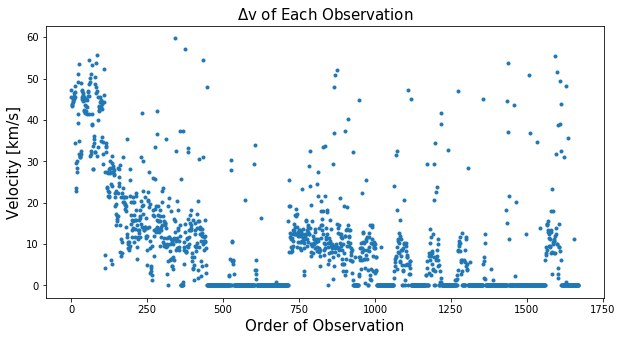

In [653]:
total_dv = np.concatenate((dvOFF, dv1,dv2,dv3), axis=0)

new_totaldv= np.array([])
for i in np.arange(len(total_dv)):
    if total_dv[i] > 80:
        new_totaldv = np.append(new_totaldv, np.mean(total_dv))
    else:
        new_totaldv = np.append(new_totaldv, total_dv[i])

plt.figure(figsize=(10,5))
plt.ylabel('Velocity [km/s]', fontsize=15)
plt.xlabel('Order of Observation',fontsize=15)
plt.title('$\Delta$v of Each Observation', fontsize=15)
plt.plot(new_totaldv,'.')

In [654]:

N_HI = 1.8e18*320*new_totaldv

In [655]:
def plot_gal_sphere2(l,b,vel,org=0, projection='mollweide'):
    ''' l, b are arrays of the same length.
    l takes values in [0,360), b in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(l+360,360) # shift az values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    tick_labels = np.array([210, 240, 270, 300, 330, 0, 30, 60, 90, 120, 150])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection=projection)
    yee = ax.scatter(np.radians(x),np.radians(b),c=vel,marker=',',vmax=3e22)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title('North Polar Spur HI Column Density',fontsize = 50)
    ax.title.set_fontsize(15)
    ax.set_xlabel("Galactic Longitude [$\degree$]",fontsize = 80)
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Galactic Latitude [$\degree$]",fontsize=80)
    ax.yaxis.label.set_fontsize(12)
    cbar = plt.colorbar(yee)
    cbar.set_label('HI Column Density [$cm^-2$]',fontsize = 20)
    
   
    ax.grid(True)

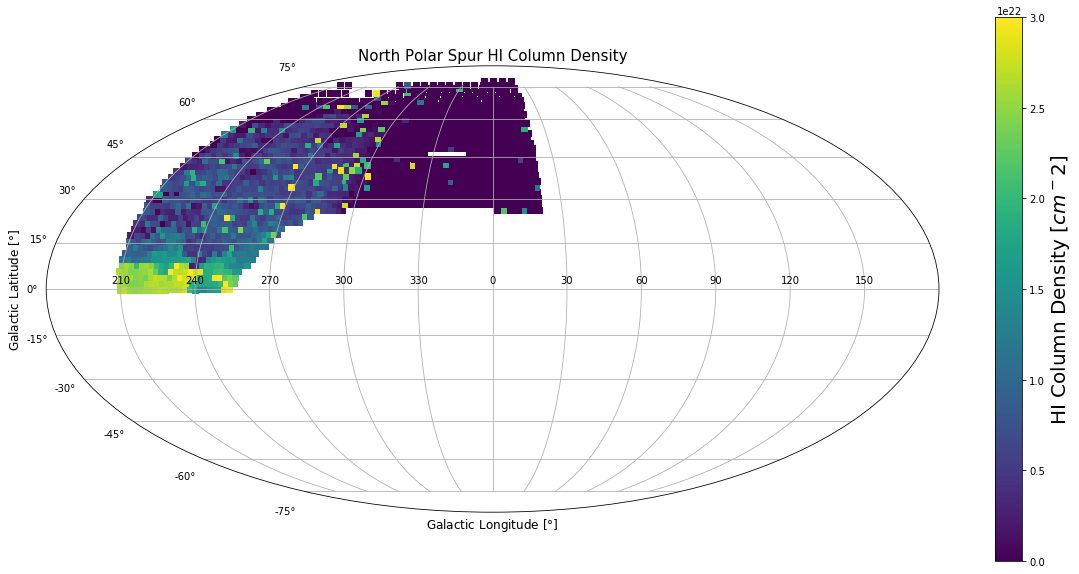

In [656]:

plot_gal_sphere2(total_glon,total_glat, N_HI)

(1671L,)

[  5.36785558e-02   1.50935437e-01   3.83503031e-01 ...,   3.59548230e+02
   3.59692662e+02   3.59986992e+02]
